Here is the sequence of operations to process single cell data and find relative ages of single cells
Select only one data set in a time, skip the rest.
Grover data have reverse order of appearance of old and young cells, also reversed aging score, which all together feels like an annotation flop. When adjusted to other sets in the same order (first young , then old cells), then it behaves equally to others. Make proper adjustments for this set. Now all script parameters are adjusted for three other data sets.


In [1]:
#import needed stuff
import math, os
import numpy as np, matplotlib.pyplot as plt
#from sklearn import preprocessing as sp
from sklearn.decomposition import PCA
#I still like to use own function to get data from file
def getitems(fil, split):
    sfil=open(fil, "r"); lines=sfil.readlines(); sfil.close()
    items=[x.rstrip().replace("'","").replace('"','').split(split) for x  in lines]
    return(items)
print("Imports")

Imports


In [2]:
"""
#First we load AL file and select AS genes. We have to keep separate negative and positive AS genes 
Positive will add to the score as they higher and negative will add as they are lower
"""
#read the file
dr = '/Users/leonid/Documents/Publications_Presentations/2020/AgingSign/data/aging_py/'
fi= 'Aging_List_REAN_Feb6.txt'
items=getitems(dr+fi, "\t")[1:]
#get AS genes, those with citation >3
ASlines=[x for x in items if float(x[1])>3]
#print(ASlines)
#get list of negative genes, those which fold change is negative
neg=[x[0] for x in ASlines if float(x[2])<0]
print("neg", neg[:5],"...")
#similarly, get positive AS genes
pos=[x[0] for x in ASlines if float(x[2])>0]
print("pos", pos[:5],"...")
ASgenes=neg+pos
nm="Flt3"#Clca3a1
if nm in ASgenes:   
    print(nm, " in ASgenes")

neg ['Flt3', 'Rassf4', 'Ebi3', 'Nrk', 'Il12rb2'] ...
pos ['Mt2', 'Plscr2', 'Selp', 'Clca3a1', 'Bmpr1a'] ...
Flt3  in ASgenes


In [4]:
# probably good place to set default directory
# define it where your source files are
os.chdir("/Users/leonid/Documents/JournalClub/sources/")
os.getcwd()


'/Users/leonid/Documents/JournalClub/sources'

In [5]:
f_in="Grover_count_filteredcorr.txt"
items=getitems(f_in,"\t") #these are lists per row
cells=items[0][1:] #these are samples names
#find samples and indexes for young and old
youngID, oldID, age=[],[],[]
for i in range(len(cells)):
    if "young" in cells[i]:
        youngID.append(i)
        age.append(0)
    if "old" in cells[i]:
        oldID.append(i)
        age.append(1)
print("young", min(youngID),max(youngID)) #indexes for young cells
print("old", min(oldID),max(oldID)) #indexes for old cells

young 0 47
old 48 116


All data points 1518075
All non-zero 664193
All zero 853882
Sparsity 0.5624768209739308


Text(0.5, 1.0, 'Log2 transformed data')

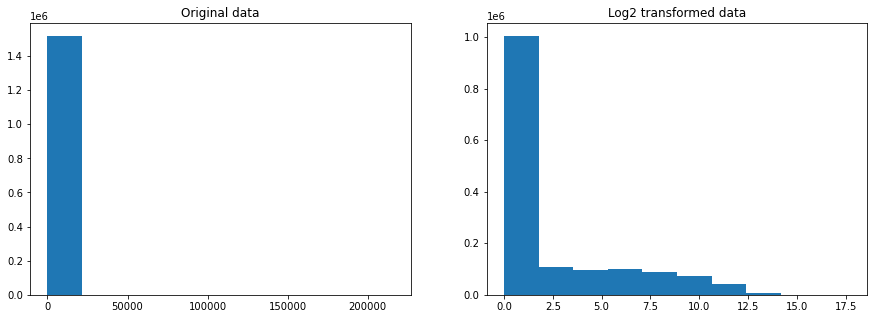

In [6]:
#check how data look like
from scipy import sparse
all_n, all_L=[],[] #data as is or log-transformed
for line in items[1:]:
    values_n=[int(x) for x in line[1:]]
    values_L=[math.log2(int(x)+1) for x in line[1:]]
    all_n+=values_n
    all_L+=values_L
print("All data points", len(all_n))
sparse_matrix=sparse.find(all_n)
print("All non-zero", len(sparse_matrix[2]))
print("All zero", len(all_n)-len(sparse_matrix[2]))
print("Sparsity", (len(all_n)-len(sparse_matrix[2]))/len(all_n))
plt.figure(figsize=[15,5]) #adjust the figure height and width to you browser screen
plt.subplot(121)
plt.title("Original data")
plt.hist(all_n)
plt.subplot(122)
plt.hist(all_L)
plt.title("Log2 transformed data")

If the figure on the left looks like one lonely block at zero, it means data are not log-transformed.
If you see a shoulder in some range next to the block, it is likely log-transformed.

In [7]:
#log-transform data if they are not
logged, genes=[],[]
for line in items[1:]:
    logged.append([math.log2(int(x)+1) for x in line[1:]])
    genes.append(line[0])
    

median totals 29418.079678075275


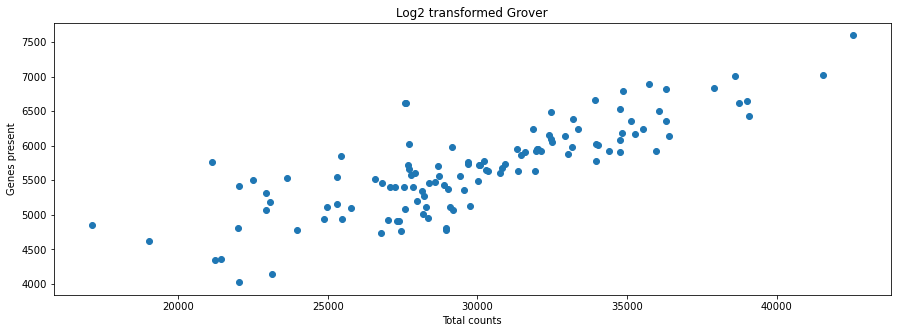

In [8]:
#check how data are normalised
#data=np.array([x for x in items[1:]]).T
data=np.array(logged).T
totals, present=[],[]
for idx, d in enumerate(data):
    values=[float(x) for x in d]
 #   print("totals in sample ", idx, sum(values))
    totals.append(sum(values))
    present.append(len([x for x in values if x>0]))
plt.figure(figsize=[15,5]) 
plt.scatter(totals, present)
#Adjust title to the data you use!
plt.title("Log2 transformed Grover")
plt.xlabel("Total counts")
plt.ylabel("Genes present")
print("median totals", np.median(totals))

median totals 28314.999999999956


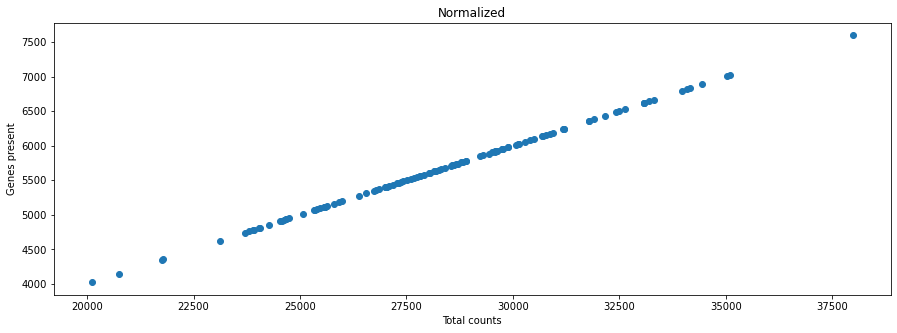

In [9]:
#normalize if not yet done
new=[] #new will be normalized data
new.append(genes) #append gene names
t,p=[],[] #new totals and present
for i in range(len(data)):
    #here we normalize to the same median per totals per gene numbers
    #note a coefficient (4,5,6 or close)
    #you can leave it as it is, or change slightly to adjust normalized data to ste same median as above
    values=[float(x)*5*present[i]/totals[i] for x in data[i]]
    new.append(values)
    t.append(sum(values))
    p.append(len([x for x in values if x>0]))
plt.figure(figsize=[15,5]) 
plt.scatter(t, p)
plt.title("Normalized")
plt.xlabel("Total counts")
plt.ylabel("Genes present")
print("median totals", np.median(t))

In [10]:
#before you reduce the table to AS genes you can inquire for any gene in the set
nm="Flt3" #gene name of your choice
print(nm)
my_gene=[x for x in np.array(new).T if x[0]==nm][0][1:]
#print(len(my_gene), my_gene)
#or
print("young cells", len(my_gene[:max(youngID)]),my_gene[:max(youngID)])
print("old cells", len(my_gene[max(youngID):]),my_gene[max(youngID):]) 

Flt3
young cells 47 ['0.0' '1.5919475256821842' '0.0' '5.1496835967668' '1.8993387349814672'
 '0.0' '0.0' '0.0' '0.851263795217545' '0.0' '0.0' '0.8424679427111352'
 '0.0' '0.0' '0.0' '0.0' '0.8881996406300077' '2.627256697351115'
 '0.9046681090621895' '0.0' '0.0' '2.379925457320866' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.8620137386510516' '0.9052593638499459'
 '9.190236937712362' '0.9611968579644593' '0.0' '0.0' '3.1047483554950173'
 '0.0' '5.68585693682921' '0.0' '0.0' '0.0' '1.8444190146767538'
 '9.885523398500078' '0.0' '10.56159778249155' '0.8746739169995466' '0.0'
 '0.0']
old cells 70 ['1.428044136058356' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '6.1405801432479965' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' 

In [13]:
#reduce the table only to the genes present in the AS list

selected=[x for x in np.array(new).T if x[0] in ASgenes]
print("length selected", len(selected))
genes=[x[0] for x in selected]
print("genes", len(genes))
#print("selected", selected[0])
if "Clca3a1" in genes:
    print("Clca3a1 still there")
else:
    print("Clca3a1 not in this set")

length selected 211
genes 211
Clca3a1 not in this set


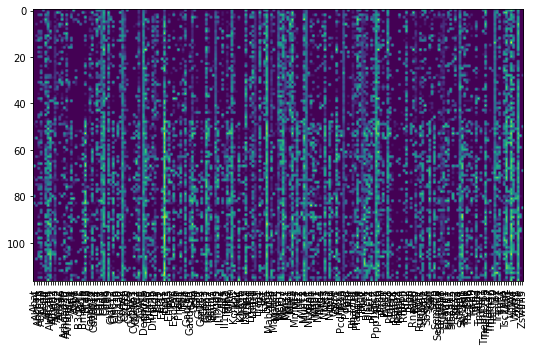

In [14]:
#try to estimate sparcity, draw heatmap
values=[]
for series in selected:
    v=[float(x) for x in series[1:]]
    values.append(v)
plt.figure(figsize=[15,5])
plt.imshow(np.array(values).T); #was values
plt.xticks(range(len(genes)), labels=genes, rotation='vertical');

0 Abat -1.579567998072066 0.11695253512625431
1 Abca4 -1.7966331629485572 0.07501893700004597
2 Abcb1a -0.7897280532389797 0.43131192740212165
3 Abcb1b -0.967554467785818 0.33529736116751174
4 Acpp 0.9674455129082126 0.33535156662807875
5 Acsl4 -0.6623757782198613 0.5090556988977819
6 Alcam -3.3656781667686624 0.0010385727933094919
7 Aldh1a1 -7.195199732842923 6.838831706180573e-11
8 Amotl2 -2.320707726881268 0.022065280596841274
9 Ampd3 -3.1873347474098432 0.0018494807970639872
10 Antxr2 3.658681271725302 0.00038408170457613787
11 Anxa2 1.448754921638923 0.15012728112111823
12 Anxa6 3.4006171228260134 0.0009251909784306168
13 Arhgap29 -3.0153019728263066 0.0031598395983473823
14 Arhgap30 1.5754108516580159 0.11790871910752158
15 Arhgef28 -1.4653940011238022 0.14554222609005024
16 Art4 -4.3585399944219 2.8634290455478714e-05
17 Asb4 -0.03291263915869769 0.9738013097719456
18 Aspa -1.060699521768313 0.2910490769977179
19 B3galt1 -0.6258394910865008 0.5326603531099343
20 Bcl6 -1.13381221

Text(0, 0.5, 'Averages')

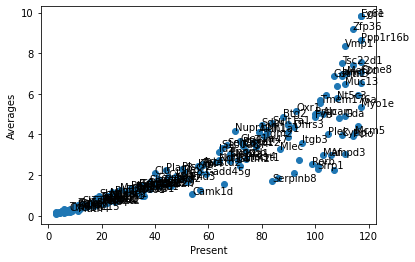

In [15]:
#plot normalized data and 
#check per gene (skip for RNAseq data)
import scipy.stats as ss
present, averages, totals, sigs=[],[],[],[]
for series in values:
    pre=[x for x in series if float(x)>0]
    #add t-test for young and old
    yo=[float(x) for x in series[:max(youngID)]]
    ol=[float(x) for x in series[max(youngID):]]
    stat, pval =ss.ttest_ind(yo, ol)
    print(values.index(series), genes[values.index(series)], stat, pval)
    if pval<0.05:
        sigs.append(genes[values.index(series)])
    ave=np.mean(series)
    tot=sum(series)
    present.append(len(pre))
    averages.append(ave)
    totals.append(tot)
for i in range(len(genes)):
    #can test fold diff and p-val for t-test
    #present as volcano, dot size by present
 #   print(genes[i],present[i],averages[i],totals[i])
    if genes[i] in sigs:
        plt.text(present[i],averages[i], genes[i])
plt.scatter(present, averages)
plt.xlabel("Present")
plt.ylabel("Averages")
#plt.hist(present)

In [16]:
#make list of scores
data=np.array([x[1:] for x in selected])#.T
scores=[0]*len(data[0]) #generate empty list to collect scores per cell
#transpose back to genes in rows and normalize again per gene
#new=sp.normalize(data, axis=1, norm="l2")
#or not
new=data#.T
print("check lengthes of genes and data", len(genes), len(new))

check lengthes of genes and data 211 211


In [17]:
#for each column add values for pos and subtract for neg
for i in range(len(genes)):
    if genes[i] in pos:
        for j in range(len(scores)):
            scores[j]+=float(new[i][j])
    if genes[i] in neg:
        for j in range(len(scores)):
            scores[j]-=float(new[i][j])
print(scores[:10],"...\n", len(scores), min(scores), max(scores))

[147.24216078678515, 145.80504440421464, 270.02443956393296, 236.93349505096717, 190.0696147506432, 232.98059693835972, 161.2293674419744, 228.45146247641864, 136.38956223549906, 171.80099269284258] ...
 117 69.07094492528772 683.491303991556


In [18]:
#scale scores to 0-1 interval
sco=[(x-min(scores))/max(scores) for x in scores]
scores=sco
print("new scores", scores[:10],"...\n", min(scores), max(scores))

new scores [0.11437046148938738, 0.11226785041858398, 0.29401031653963494, 0.2455957363983569, 0.17703029887685348, 0.23981234443781155, 0.13483481352064902, 0.23318587467076238, 0.09849228061436024, 0.15030190898935564] ...
 0.0 0.8989439301979166


In [19]:
#this is PCA for all data
X = new.T
pca = PCA(n_components=3)
pcomp=pca.fit_transform(X)
pc1=pcomp.T[0]
pc2=pcomp.T[1]
print(len(pc1), len(pc2))
print("Explained variance", pca.explained_variance_ratio_)

117 117
Explained variance [0.13871944 0.03161601 0.02652075]


In [20]:
pc1_genes=pca.components_[0]
print("len pc1", len(pc1_genes))
print("Genes in 1st component")
sort=sorted(zip(pc1_genes, genes), reverse=True)
for i in range(len(sort)):
    if abs(sort[i][0])>0.12:
        print(i, sort[i])
pc2_genes=pca.components_[1]
print("Genes in 2nd component")
sort=sorted(zip(pc2_genes, genes), reverse=True)
for i in range(len(sort)):
    if abs(sort[i][0])>0.12:
        print(i, sort[i])

len pc1 211
Genes in 1st component
0 (0.21404909786113313, 'Sdpr')
1 (0.20906827929155283, 'Nupr1')
2 (0.20238848719705527, 'Sult1a1')
3 (0.19323879493967053, 'Btg2')
4 (0.16995630976565748, 'Egr1')
5 (0.1671519304761919, 'Gda')
6 (0.16650512654976357, 'Selp')
7 (0.1649197527605841, 'Mt1')
8 (0.1603811867576715, 'Clec1a')
9 (0.1559723341689811, 'Id2')
10 (0.15245299481547225, 'Aldh1a1')
11 (0.1478993008713335, 'Gstm1')
12 (0.14534151689294494, 'Itgb3')
13 (0.13678943532344393, 'Enpp5')
14 (0.13630669786867095, 'Klhl4')
15 (0.13013818751685935, 'Clu')
16 (0.12998186084752325, 'Tgm2')
17 (0.12453267354044684, 'Oxr1')
Genes in 2nd component
0 (0.2413210165537672, 'Slc14a1')
1 (0.2270000741118133, 'Rfc2')
2 (0.19453552333671018, 'Tacstd2')
3 (0.18535961967789244, 'Oxr1')
4 (0.17765060371018906, 'Cd34')
5 (0.1655052030121349, 'Aldh1a1')
6 (0.15974427536951388, 'Fyb')
7 (0.15948894627736937, 'Cd9')
8 (0.15585685244767777, 'Sdpr')
9 (0.15308887140858504, 'Cd63')
10 (0.14626304352473876, 'Mcm7

In [21]:
#try to pick some gene for coloring
gene_to_color= "Selp"
print(len(new),len(genes))
for i in range(len(genes)):
    if genes[i]==gene_to_color:
        val=[float(x) for x in new[i]]
        break
val_to_color=[x/max(val) for x in val]
#you can check all data together
print(len(pc1))
print(len(pc2))
print(len(val_to_color))

211 211
117
117
117


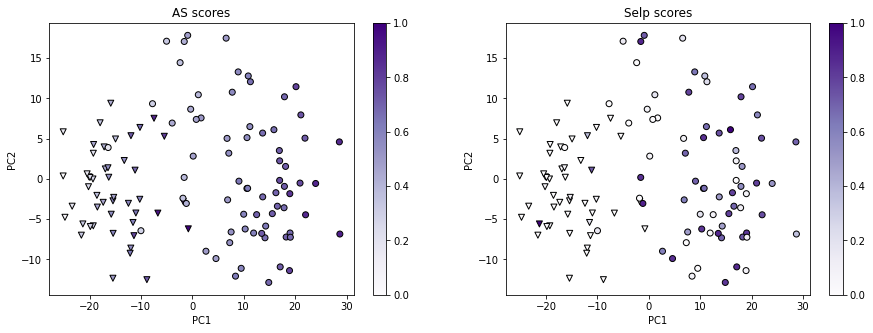

In [22]:
thresh=max(youngID)
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.title("AS scores")
plt.scatter(pc1[:thresh],pc2[:thresh],marker="v", edgecolor="black",
            cmap="Purples", 
            c=scores[:thresh])
plt.scatter(pc1[thresh:],pc2[thresh:],marker="o",edgecolor="black",
            cmap="Purples", 
            c=scores[thresh:])
plt.colorbar()
plt.clim(0,1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.subplot(122)
plt.scatter(pc1[:thresh],pc2[:thresh],marker="v",edgecolor="black",
            cmap="Purples", 
            c=val_to_color[:thresh])
plt.scatter(pc1[thresh:],pc2[thresh:],marker="o",edgecolor="black",
            cmap="Purples", 
            c=val_to_color[thresh:])
#for i in range(len(cells)):
 #   plt.text(pc1[i],pc2[i],cells[i][0:1])

plt.title(gene_to_color+ " scores")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.clim(0,1)

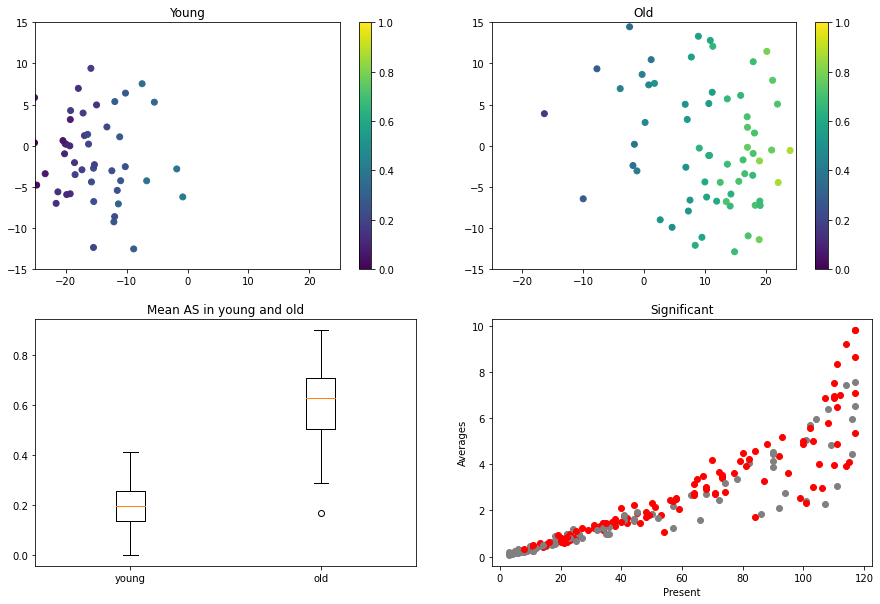

In [23]:
plt.figure(figsize=[15,10])
plt.subplot(221)
plt.title("Young")
#for i in range(0,48): 
 #   plt.text(pc1[i],pc2[i], cells[i][:3])
plt.scatter(pc1[0:thresh],pc2[0:thresh], c=scores[0:thresh])
plt.clim(0,1)
plt.colorbar()    
plt.xlim(-25,25)
plt.ylim(-15,15)
plt.subplot(222)
#for i in range(47,len(cells)):
 #   plt.text(pc1[i],pc2[i], cells[i][:3])
plt.scatter(pc1[thresh:],pc2[thresh:], c=scores[thresh:])
plt.clim(0,1)
plt.colorbar()
plt.xlim(-25,25)
plt.ylim(-15,15)
plt.title("Old")
plt.subplot(223)
plt.title("Mean AS in young and old")
plt.boxplot([scores[:thresh], scores[thresh:]])
plt.xticks([1,2], ["young", "old"])
plt.subplot(224)
for i in range(len(genes)):
    #can test fold diff and p-val for t-test
    #present as volcano, dot size by present
 #   print(genes[i],present[i],averages[i],totals[i])
    if genes[i] in sigs:
        plt.scatter(present[i],averages[i], c='red')
        #plt.text(present[i],averages[i], genes[i])
    else:
        plt.scatter(present[i], averages[i], c='gray')
plt.xlabel("Present")
plt.ylabel("Averages")
plt.title("Significant")
#plt.scatter(t, p)
plt.show()

In [24]:
"""extra if you want it. Find how successful 
is prediction based on any kind of selected data
first, define which data to use and give indexes of ages
"""
#run random forest
X=np.array(selected).T[1:] #was data
genes=np.array(selected).T[0] 
y=age
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
print("success of prediction, score:", clf.score(X, y))
imp=clf.feature_importances_
sort=sorted(zip(imp, genes), reverse=True)
print("Random forest age predictors")
for i in range(len(sort))[:10]:
    if sort[i][0]>0:
        print(i, sort[i])


success of prediction, score: 1.0
Random forest age predictors
0 (0.09702153993606456, 'Sdpr')
1 (0.09126973749680735, 'Mt1')
2 (0.06846803210128728, 'Nupr1')
3 (0.06235916329747951, 'Aldh1a1')
4 (0.05455411491992226, 'Plscr2')
5 (0.04472423069402299, 'Sult1a1')
6 (0.043894719210145886, 'Klhl4')
7 (0.04267584268297709, 'Selp')
8 (0.04106253295951632, 'Enpp5')
9 (0.030820914993006113, 'Btg2')


In [24]:
print("That's all, folks!")

That's all, folks!
